In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from PIL import Image # To convert numpy array to PIL Image for transforms
from transformers import ConvNextV2ForImageClassification, AutoImageProcessor
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from collections import Counter
import glob
from tqdm import tqdm
import zipfile
from itertools import cycle

In [3]:
zip_path = 'lens-finding-test.zip'  
extract_to = 'dataset/'  

# Create directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [10]:
from collections import defaultdict

# Replace with your main folder path
main_folder = "dataset"

# Dictionary to hold folder name and number of files
folder_file_count = defaultdict(int)

# Loop through the contents of the main folder
for item in os.listdir(main_folder):
    item_path = os.path.join(main_folder, item)
    if os.path.isdir(item_path):
        num_files = sum(len(files) for _, _, files in os.walk(item_path))
        folder_file_count[item] = num_files

# Print the results
for folder, count in folder_file_count.items():
    print(f"Folder: {folder} -> {count} files")

Folder: test_lenses -> 195 files
Folder: test_nonlenses -> 19455 files
Folder: train_lenses -> 1730 files
Folder: train_nonlenses -> 28675 files


In [11]:
# --- Configuration ---
MODEL_NAME = "facebook/convnextv2-tiny-1k-224" # Pretrained model identifier
DATA_ROOT = "dataset"  # <<<--- IMPORTANT: Update this path to where you extracted the dataset folder
# Expected structure:
# task2_data/train_lenses/image1.npy
# task2_data/train_nonlenses/image2.npy
# task_data/test_lenses/image3.npy
# task_data/test_nonlenses/image4.npy

NUM_CLASSES = 2 # Binary classification: lens (1) vs non-lens (0)
BATCH_SIZE = 100 # Adjust based on GPU VRAM (Start with 64 or 128 for A4000)
EPOCHS = 20     # Number of training epochs (adjust based on convergence)
LEARNING_RATE = 3e-5 # Learning rate for fine-tuning (AdamW)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 10 # Number of CPU workers for data loading (adjust based on system)
SEED = 42 # For reproducibility

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")
print(f"Using model: {MODEL_NAME}")
print(f"Data root: {DATA_ROOT}")


Using device: cuda
Using model: facebook/convnextv2-tiny-1k-224
Data root: dataset


File Counts:
  Split: train
    Class 'train_lenses': 1730 files
    Class 'train_nonlenses': 28675 files
  Total for train: 30405
  Split: test
    Class 'test_lenses': 195 files
    Class 'test_nonlenses': 19455 files
  Total for test: 19650
Grand Total: 50055


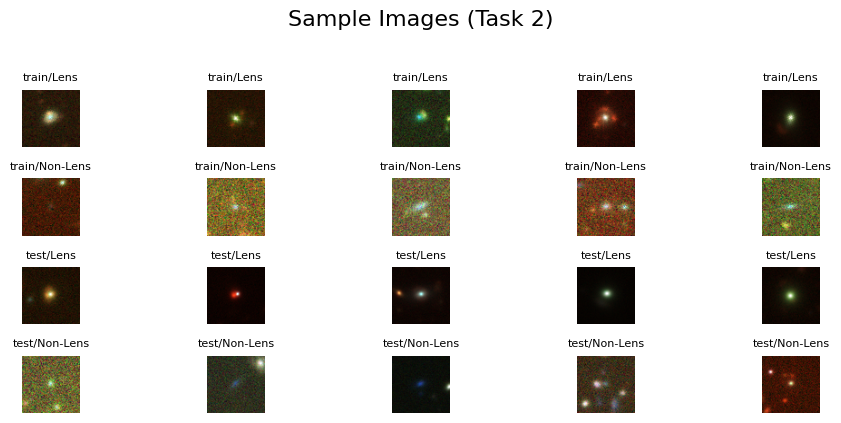

In [12]:
# --- Helper Function: Count Files ---
def count_files_task2(root_dir):
    counts = {}
    splits = ['train', 'test']
    classes_suffix = ['lenses', 'nonlenses']
    total_count = 0
    print("File Counts:")
    for split in splits:
        counts[split] = {}
        print(f"  Split: {split}")
        split_total = 0
        for cls_suffix in classes_suffix:
            folder_name = f"{split}_{cls_suffix}"
            class_dir = os.path.join(root_dir, folder_name)
            count = 0
            if os.path.isdir(class_dir):
                try:
                    file_list = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
                    count = len(file_list)
                except Exception as e:
                    print(f"    Error counting files in {class_dir}: {e}")
            else:
                print(f"    Warning: Directory not found {class_dir}")

            counts[split][folder_name] = count
            print(f"    Class '{folder_name}': {count} files")
            split_total += count
        print(f"  Total for {split}: {split_total}")
        total_count += split_total
    print(f"Grand Total: {total_count}")
    return counts

# Count files in the dataset.
dataset_counts = count_files_task2(DATA_ROOT)

# --- Helper Function: Plot Samples ---
def plot_samples_task2(root_dir, num_samples=5):
    """ Plots samples for lens and non-lens classes from train and test sets. """
    splits = ['train', 'test']
    classes_plot = ['lenses', 'nonlenses'] # Binary classes
    class_labels = {'lenses': 'Lens', 'nonlenses': 'Non-Lens'} # Nicer labels for plot
    num_classes_plot = len(classes_plot)
    plt.figure(figsize=(num_samples * 2, len(splits) * 2.2)) # Adjusted size
    plot_idx = 1
    for split in splits:
        for cls_plot in classes_plot:
            folder_name = f"{split}_{cls_plot}"
            class_dir = os.path.join(root_dir, folder_name)
            if not os.path.isdir(class_dir):
                 print(f"Skipping plot for missing directory: {class_dir}")
                 # Add empty plots to maintain grid structure if needed
                 for _ in range(num_samples):
                     if plot_idx <= len(splits) * num_classes_plot * num_samples:
                          ax = plt.subplot(len(splits) * num_classes_plot, num_samples, plot_idx)
                          ax.text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=8)
                          ax.set_title(f"{split}/{class_labels[cls_plot]}", fontsize=8)
                          ax.axis('off')
                          plot_idx += 1
                 continue

            files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
            if not files:
                print(f"No .npy files found in {class_dir} for plotting.")
                # Add empty plots
                for _ in range(num_samples):
                     if plot_idx <= len(splits) * num_classes_plot * num_samples:
                        ax = plt.subplot(len(splits) * num_classes_plot, num_samples, plot_idx)
                        ax.text(0.5, 0.5, "No Files", ha='center', va='center', fontsize=8)
                        ax.set_title(f"{split}/{class_labels[cls_plot]}", fontsize=8)
                        ax.axis('off')
                        plot_idx += 1
                continue

            actual_num_samples = min(num_samples, len(files))
            selected_files = random.sample(files, actual_num_samples)

            for i in range(actual_num_samples):
                if plot_idx > len(splits) * num_classes_plot * num_samples: break # Safety break
                ax = plt.subplot(len(splits) * num_classes_plot, num_samples, plot_idx)
                try:
                    img = np.load(os.path.join(class_dir, selected_files[i]))
                    if img.shape == (3, 64, 64):
                        img_plot = np.transpose(img, (1, 2, 0)) # CHW to HWC
                        min_val, max_val = img_plot.min(), img_plot.max()
                        if max_val > min_val: img_plot = (img_plot - min_val) / (max_val - min_val)
                        ax.imshow(img_plot)
                    else: ax.text(0.5, 0.5, f"Shape:\n{img.shape}", ha='center', va='center', fontsize=8)
                except Exception as e:
                    ax.text(0.5, 0.5, "Error", ha='center', va='center', fontsize=8)
                    print(f"Error loading {selected_files[i]} for plot: {e}")

                ax.set_title(f"{split}/{class_labels[cls_plot]}", fontsize=8)
                ax.axis('off')
                plot_idx += 1
            # Fill remaining slots if actual_num_samples < num_samples
            for _ in range(num_samples - actual_num_samples):
                 if plot_idx <= len(splits) * num_classes_plot * num_samples:
                      ax = plt.subplot(len(splits) * num_classes_plot, num_samples, plot_idx)
                      ax.text(0.5, 0.5, " ", ha='center', va='center') # Empty placeholder
                      ax.set_title(f"{split}/{class_labels[cls_plot]}", fontsize=8)
                      ax.axis('off')
                      plot_idx += 1


    plt.suptitle(f"Sample Images (Task 2)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot some samples
plot_samples_task2(DATA_ROOT, num_samples=5)


In [14]:
# --- Dataset Class ---
class LensFindingDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.transform = transform
        self.samples = []
        self.labels_for_weights = [] # Only populated for split='train'

        lenses_dir = os.path.join(root_dir, f"{split}_lenses")
        nonlenses_dir = os.path.join(root_dir, f"{split}_nonlenses")

        # Process lenses (label 1)
        if os.path.isdir(lenses_dir):
            for filename in glob.glob(os.path.join(lenses_dir, '*.npy')):
                self.samples.append((filename, 1))
                if split == 'train': self.labels_for_weights.append(1)
        else: print(f"Warning: Directory not found {lenses_dir}")

        # Process non-lenses (label 0)
        if os.path.isdir(nonlenses_dir):
            for filename in glob.glob(os.path.join(nonlenses_dir, '*.npy')):
                self.samples.append((filename, 0))
                if split == 'train': self.labels_for_weights.append(0)
        else: print(f"Warning: Directory not found {nonlenses_dir}")

        print(f"Loaded {len(self.samples)} samples for {split} split.")
        if split == 'train' and self.labels_for_weights:
            counts = Counter(self.labels_for_weights)
            print(f"Train class counts: {counts}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        try:
            image_np = np.load(file_path).astype(np.float32)

            # Verify and potentially fix shape
            if image_np.shape == (3, 64, 64):
                pass # Correct shape
            elif image_np.shape == (64, 64, 3):
                image_np = np.transpose(image_np, (2, 0, 1)) # Convert HWC to CHW
            else:
                 # Try to handle common single channel case (1, 64, 64) by repeating
                 if image_np.shape == (1, 64, 64):
                      image_np = np.repeat(image_np, 3, axis=0)
                 else:
                      raise ValueError(f"Unexpected shape {image_np.shape} in file {file_path}")

            image_tensor = torch.from_numpy(image_np)

            # Apply transformations
            if self.transform:
                image_tensor = self.transform(image_tensor)

        except Exception as e:
            print(f"Error loading or processing file {file_path}: {e}")
            return None, None # Signal error

        return image_tensor, label

# --- Transformations ---
# Load processor to get model specifics
try:
    processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)
    if isinstance(processor.size, dict):
        IMG_SIZE = processor.size.get("shortest_edge", processor.size.get("height", 224))
    elif isinstance(processor.size, int): IMG_SIZE = processor.size
    else: IMG_SIZE = 224
    IMG_MEAN = processor.image_mean
    IMG_STD = processor.image_std
except Exception as e:
    print(f"Warning: Using default size 224 and ImageNet stats due to processor error: {e}")
    IMG_SIZE = 224
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225]

print(f"Using image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Using mean: {IMG_MEAN}, std: {IMG_STD}")

# Define transforms sequences (applied to tensors)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45), # Increased rotation
    # Add more augmentations if needed (e.g., slight affine)
    # transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

# --- Datasets ---
train_dataset = LensFindingDataset(root_dir=DATA_ROOT, split="train", transform=train_transform)
test_dataset  = LensFindingDataset(root_dir=DATA_ROOT, split="test", transform=val_test_transform)

# --- Calculate Class Weights ---
if train_dataset.labels_for_weights:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]), # Explicitly define the classes expected
        y=np.array(train_dataset.labels_for_weights)
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f"Calculated class weights (for [0, 1]): {class_weights_tensor}")
else:
    print("Warning: No training labels found for weight calculation. Using default weights.")
    class_weights_tensor = torch.tensor([1.0, 1.0], dtype=torch.float).to(DEVICE)

# --- DataLoaders ---
def collate_fn(batch):
    # Filter out samples where loading failed (returned None)
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor() # Handle empty batch
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True, drop_last=True) # drop_last=True for training
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print("\nDataset sizes (after potential filtering):")
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Using image size: 224x224
Using mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]
Loaded 30405 samples for train split.
Train class counts: Counter({0: 28675, 1: 1730})
Loaded 19650 samples for test split.
Calculated class weights (for [0, 1]): tensor([0.5302, 8.7876], device='cuda:0')

Dataset sizes (after potential filtering):
Training samples: 30405
Test samples: 19650


In [15]:
# --- Model ---
print(f"\nLoading model: {MODEL_NAME}")
model = ConvNextV2ForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True # Load backbone weights, reinitialize classifier
)
model.to(DEVICE)

# --- Loss, Optimizer, Scheduler ---
print("Setting up loss, optimizer, scheduler...")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Apply class weights
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
# Monitor validation AUC (higher is better)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

# --- Training Loop ---
train_losses = []
# Use test set for validation metrics during training
val_losses = []
val_aucs = []
best_val_auc = 0.0 # Initialize best AUC to 0.0 for 'max' mode

print("\nStarting Training (using test set for validation)...")
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    # Use tqdm for progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

    for images, labels in train_loop:
        # Skip potentially empty batches from collate_fn
        if images.nelement() == 0: continue
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        # Display current batch loss in progress bar description
        train_loop.set_postfix(loss=f"{loss.item():.4f}")

    # Calculate average loss over the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset) # Use dataset length for average
    train_losses.append(epoch_train_loss)

    # --- Validation Phase (using test set) ---
    model.eval()
    running_val_loss = 0.0
    all_val_labels = []
    all_val_probs_class1 = [] # Store probs only for the positive class (lens=1)
    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val/Test]", leave=False)

    with torch.no_grad():
        for images, labels in val_loop:
            if images.nelement() == 0: continue
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs_class1.extend(probs[:, 1].cpu().numpy()) # Store prob of class 1
            val_loop.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = running_val_loss / len(test_loader.dataset) # Use dataset length for average
    val_losses.append(epoch_val_loss)

    # --- Calculate Validation AUC ---
    val_labels_np = np.array(all_val_labels)
    val_probs_np_class1 = np.array(all_val_probs_class1)
    epoch_val_auc = float('nan') # Default to NaN
    if len(val_labels_np) > 0: # Ensure there were validation samples processed
        try:
            # Check if both classes (0 and 1) are present in the labels collected
            if len(np.unique(val_labels_np)) >= NUM_CLASSES:
                epoch_val_auc = roc_auc_score(val_labels_np, val_probs_np_class1)
                val_aucs.append(epoch_val_auc)
            else:
                # If only one class seen, AUC is undefined or trivial (0.5)
                print(f"Warning: Only {len(np.unique(val_labels_np))} class(es) present in validation batch run for epoch {epoch+1}. AUC may be inaccurate.")
                val_aucs.append(0.5) # Assign 0.5 or nan
                epoch_val_auc = 0.5 # Use 0.5 for scheduler step
        except ValueError as e:
            print(f"Could not compute AUC for epoch {epoch+1}: {e}")
            val_aucs.append(float('nan'))
    else:
        print(f"Warning: No validation samples processed in epoch {epoch+1}.")
        val_aucs.append(float('nan'))


    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val/Test Loss: {epoch_val_loss:.4f}, "
          f"Val/Test AUC: {epoch_val_auc:.4f}")

    # Step scheduler based on validation AUC
    # Need a value even if AUC is nan; using -1 ensures step if patience runs out
    scheduler.step(epoch_val_auc if not np.isnan(epoch_val_auc) else -1)

    # Save best model based on validation AUC
    if not np.isnan(epoch_val_auc) and epoch_val_auc > best_val_auc:
        best_val_auc = epoch_val_auc
        # Save the model's state dictionary
        torch.save(model.state_dict(), "lensfinder_convnextv2_best_task2.pth")
        print(f"✅ New best model saved with Val/Test AUC: {best_val_auc:.4f}")

print("Training Finished!")


Loading model: facebook/convnextv2-tiny-1k-224


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up loss, optimizer, scheduler...

Starting Training (using test set for validation)...


Epoch 1/20 - Train Loss: 0.2245, Val/Test Loss: 0.1351, Val/Test AUC: 0.9802
✅ New best model saved with Val/Test AUC: 0.9802


Epoch 2/20 - Train Loss: 0.1465, Val/Test Loss: 0.0691, Val/Test AUC: 0.9803
✅ New best model saved with Val/Test AUC: 0.9803


Epoch 3/20 - Train Loss: 0.1270, Val/Test Loss: 0.0568, Val/Test AUC: 0.9867
✅ New best model saved with Val/Test AUC: 0.9867


Epoch 4/20 - Train Loss: 0.1111, Val/Test Loss: 0.0711, Val/Test AUC: 0.9859


Epoch 5/20 - Train Loss: 0.1035, Val/Test Loss: 0.0784, Val/Test AUC: 0.9873
✅ New best model saved with Val/Test AUC: 0.9873


Epoch 6/20 - Train Loss: 0.0915, Val/Test Loss: 0.0828, Val/Test AUC: 0.9880
✅ New best model saved with Val/Test AUC: 0.9880


Epoch 7/20 - Train Loss: 0.0789, Val/Test Loss: 0.0841, Val/Test AUC: 0.9867


Epoch 8/20 - Train Loss: 0.0801, Val/Test Loss: 0.0553, Val/Test AUC: 0.9867


Epoch 9/20 - Train Loss: 0.0732, Val/Test Loss: 0.0439, Val/Test AUC: 0.9904
✅ New best model saved with Val/Test AUC: 0.9904


Epoch 10/20 - Train Loss: 0.0692, Val/Test Loss: 0.0623, Val/Test AUC: 0.9900


Epoch 11/20 - Train Loss: 0.0626, Val/Test Loss: 0.0588, Val/Test AUC: 0.9899


Epoch 12/20 - Train Loss: 0.0632, Val/Test Loss: 0.0839, Val/Test AUC: 0.9903


Epoch 13/20 - Train Loss: 0.0566, Val/Test Loss: 0.0646, Val/Test AUC: 0.9920
✅ New best model saved with Val/Test AUC: 0.9920


Epoch 14/20 - Train Loss: 0.0574, Val/Test Loss: 0.0304, Val/Test AUC: 0.9906


Epoch 15/20 - Train Loss: 0.0538, Val/Test Loss: 0.0523, Val/Test AUC: 0.9925
✅ New best model saved with Val/Test AUC: 0.9925


Epoch 16/20 - Train Loss: 0.0433, Val/Test Loss: 0.0310, Val/Test AUC: 0.9908


Epoch 17/20 - Train Loss: 0.0460, Val/Test Loss: 0.0361, Val/Test AUC: 0.9907


Epoch 18/20 - Train Loss: 0.0365, Val/Test Loss: 0.0386, Val/Test AUC: 0.9918


Epoch 19/20 - Train Loss: 0.0419, Val/Test Loss: 0.0710, Val/Test AUC: 0.9892
Epoch 00019: reducing learning rate of group 0 to 6.0000e-06.


Epoch 20/20 - Train Loss: 0.0275, Val/Test Loss: 0.0362, Val/Test AUC: 0.9913
Training Finished!


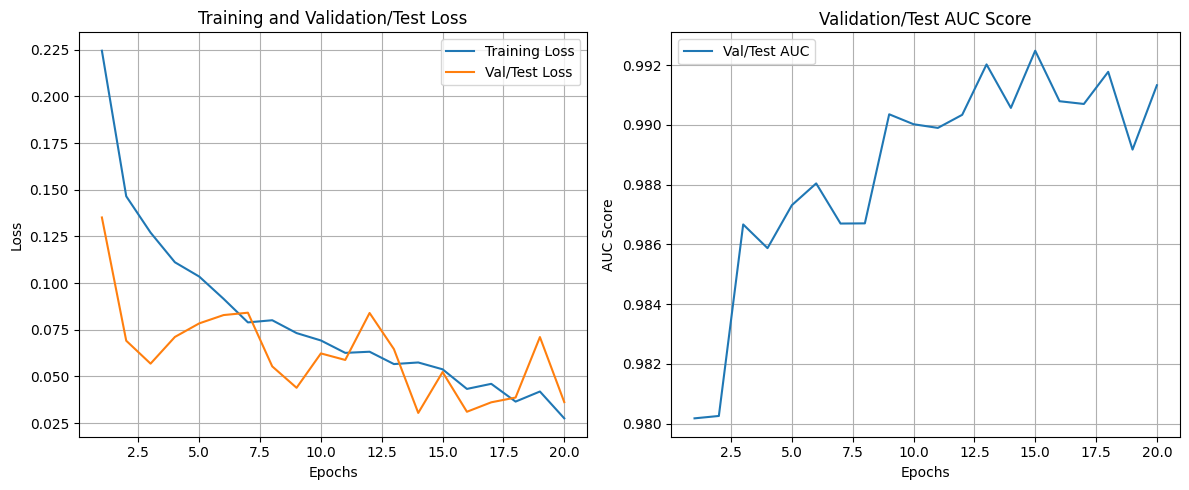


Final Evaluation on Test Set (using best model)...
Loaded best model from lensfinder_convnextv2_best_task2.pth


Final Testing: 100%|██████████| 197/197 [00:54<00:00,  3.59it/s]



Final Test Accuracy: 0.9810
Final Test ROC AUC: 0.9925

Final Classification Report (Test Set):
              precision    recall  f1-score   support

non-lens (0)       1.00      0.98      0.99     19455
    lens (1)       0.33      0.92      0.49       195

    accuracy                           0.98     19650
   macro avg       0.67      0.95      0.74     19650
weighted avg       0.99      0.98      0.99     19650



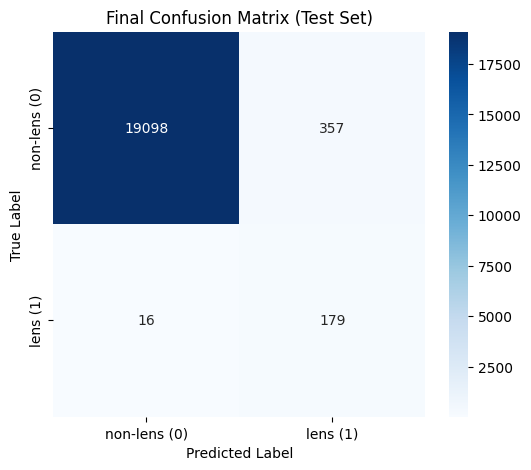

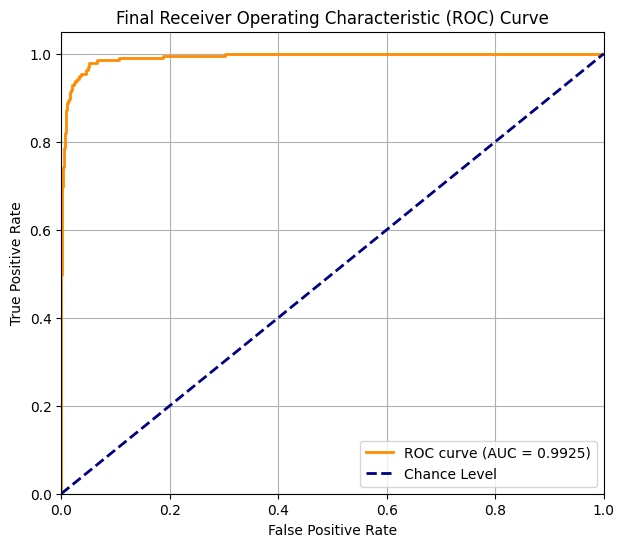

In [16]:
# --- Plotting Training History ---
fig_hist, axes_hist = plt.subplots(1, 2, figsize=(12, 5))

# Ensure lists are not empty before plotting
if train_losses:
    axes_hist[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
if val_losses:
    axes_hist[0].plot(range(1, len(val_losses) + 1), val_losses, label='Val/Test Loss')
axes_hist[0].set_xlabel('Epochs')
axes_hist[0].set_ylabel('Loss')
axes_hist[0].set_title('Training and Validation/Test Loss')
axes_hist[0].legend()
axes_hist[0].grid(True)

if val_aucs:
    # Filter out NaN values for plotting AUC, keep track of original epoch numbers
    valid_auc_indices = [i + 1 for i, auc_val in enumerate(val_aucs) if not np.isnan(auc_val)]
    valid_auc_values = [auc_val for auc_val in val_aucs if not np.isnan(auc_val)]
    if valid_auc_values: # Only plot if there are valid AUC scores
         axes_hist[1].plot(valid_auc_indices, valid_auc_values, label='Val/Test AUC')

axes_hist[1].set_xlabel('Epochs')
axes_hist[1].set_ylabel('AUC Score')
axes_hist[1].set_title('Validation/Test AUC Score')
axes_hist[1].legend()
axes_hist[1].grid(True)

fig_hist.tight_layout()
fig_hist.savefig("training_history_lensfinder_task2.png")
plt.show()
plt.close(fig_hist)


# --- Final Evaluation on Test Set ---
print("\nFinal Evaluation on Test Set (using best model)...")
best_model_path = "lensfinder_convnextv2_best_task2.pth"
if os.path.exists(best_model_path):
    try:
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded best model from {best_model_path}")
    except Exception as e:
        print(f"Error loading best model weights: {e}. Evaluating model from last epoch.")
else:
    print("Warning: Best model checkpoint not found. Evaluating the model from the last epoch.")

model.to(DEVICE)
model.eval()

all_test_labels = []
all_test_preds_classes = []
all_test_probs_class1 = [] # Probabilities for the positive class (lens)

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Final Testing"):
        if images.nelement() == 0: continue
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(pixel_values=images).logits
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds_classes.extend(preds.cpu().numpy())
        all_test_probs_class1.extend(probs[:, 1].cpu().numpy()) # Get prob for class 1

test_labels_np = np.array(all_test_labels)
test_preds_np = np.array(all_test_preds_classes)
test_probs_np_class1 = np.array(all_test_probs_class1)

# Calculate final metrics
if len(test_labels_np) > 0: # Ensure test data was processed
    test_accuracy = (test_preds_np == test_labels_np).mean()
    try:
        test_auc = roc_auc_score(test_labels_np, test_probs_np_class1)
    except ValueError as e:
        print(f"Could not compute final test AUC: {e}")
        test_auc = float('nan')

    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test ROC AUC: {test_auc:.4f}")

    # Classification Report
    target_names = ['non-lens (0)', 'lens (1)']
    print("\nFinal Classification Report (Test Set):")
    # Add zero_division=0 to handle cases where a class might have no predicted samples
    print(classification_report(test_labels_np, test_preds_np, target_names=target_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(test_labels_np, test_preds_np)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Final Confusion Matrix (Test Set)')
    plt.savefig("confusion_matrix_lensfinder_task2.png")
    plt.show()
    plt.close()

    # Final ROC Curve
    if not np.isnan(test_auc): # Only plot if AUC is valid
        fpr, tpr, thresholds = roc_curve(test_labels_np, test_probs_np_class1)
        roc_auc_value = auc(fpr, tpr) # Use sklearn.metrics.auc

        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Final Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig("roc_curve_test_lensfinder_task2.png")
        plt.show()
        plt.close()
    else:
        print("Skipping ROC curve plot because AUC could not be calculated.")

else:
    print("No test data processed, skipping final evaluation metrics.")